# Sprint 深層学習スクラッチ ニューラルネットワーク

## Sprintの目的
スクラッチを通してニューラルネットワークの基礎を理解する
画像データの扱い方を知る

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: F

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


### 平滑化

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

### 画像データの可視化

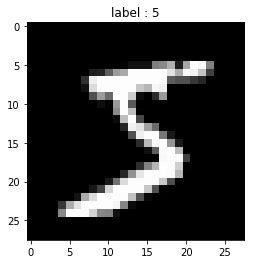

In [5]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

#### 《発展的話題》

### 前処理

In [6]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [7]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [8]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train.shape =", X_train_.shape) # (48000, 784)
print("X_val.shape =", X_val.shape) # (12000, 784)
print("y_train.shape =", y_train_.shape) # (48000, 784)
print("y_val.shape =", y_val.shape) # (12000, 784)

X_train.shape = (48000, 784)
X_val.shape = (12000, 784)
y_train.shape = (48000, 10)
y_val.shape = (12000, 10)


## ニューラルネットワークスクラッチ

In [73]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, num_epoch=10, lr=0.01, verbose=True):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.w1 = None
        self.w2 = None
        self.w3 = None
        self.A1 = None
        self.A2 = None
        self.A3 = None
        self.Z1 = None
        self.Z2 = None
        self.Z3 = None
        self.loss = None
        self.val_loss = None
        
        self.a1 = []
        self.a2 = []
        self.b = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
        batch_size = 20 # バッチサイズ
        n_features = 784 # 特徴量の数
        n_nodes1 = 400 # 1層目のノード数
        n_nodes2 = 200 # 2層目のノード数
        n_output = 10 # 出力のクラス数（3層目のノード数）
        
        self.w1 = self.w_init(n_features, n_nodes1)
        self.w2 = self.w_init(n_nodes1, n_nodes2)
        self.w3 = self.w_init(n_nodes2, n_output)
        
        self.B1 = self.w_init(1,self.w1.shape[1])
        self.B2 = self.w_init(1,self.w2.shape[1])
        self.B3 = self.w_init(1,self.w3.shape[1])
        
        self.loss = []
        self.val_loss = []
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
            """
            self.forward_propagation(X)
            self.back_propagation(X, y)
            """
            
            self.loss.append(np.average(self.loss_func(y, self.forward_propagation(X))))
            if self.val_enable:
                self.val_loss.append(np.average(self.loss_func(y_val, self.forward_propagation(X_val))))
        
        print()
        if self.verbose:
            self.learning_curve()
            print()

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def w_init(self, n_features, n_nodes):
        sigma = 1e-2 # ガウス分布の標準偏差
        w = sigma * np.random.randn(n_features, n_nodes)
        return w
    
    def forward_propagation(self, X):
        self.A1 = X@self.w1 + self.B1
        self.Z1 = self.tanh(self.A1)
        self.A2 = self.Z1@self.w2 + self.B2
        self.Z2 = self.tanh(self.A2)
        self.A3 = self.Z2@self.w3 + self.B3
        self.Z3 = self.softmax(self.A3)
        return self.Z3
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def tanh(self, X):
        return np.tanh(X)
    
    def softmax(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
    
    def loss_func(self, y_true, z):
        """
        y_true : (n_samples, n_output)
        z : (n_samples, n_output)
        """
        return (-1)*np.average(np.sum(y_true*np.log(z), axis=1))
    
    def back_propagation(self, X, y_true):
        """
        y_true : (n_samples, n_output)
        """
        L_A3 = self.Z3 - y_true #(Z3.shape[1],)
        L_B3 = L_A3
        L_w3 = self.Z2.T@L_A3
        L_Z2 = L_A3@self.w3.T
        
        L_A2 = L_Z2 * (1 - (self.tanh(np.average(self.A2)))**2)
        L_B2 = L_A2
        L_w2 = self.Z1.T@L_A2
        L_Z1 = L_A2@self.w2.T
        
        L_A1 = L_Z1 * (1 - (self.tanh(np.average(self.A1)))**2)
        L_B1 = L_A1
        L_w1 = X.T@L_A1
        
        self.w1 = self.w1 - self.lr*L_w1
        self.w2 = self.w2 - self.lr*L_w2
        self.w3 = self.w3 - self.lr*L_w3
        
        self.B1 = self.B1 - self.lr*np.average(L_B1, axis=0)
        self.B2 = self.B2 - self.lr*np.average(L_B2, axis=0)
        self.B3 = self.B3 - self.lr*np.average(L_B3, axis=0)
        
        return
    
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(self.num_epoch), self.loss, label="train_loss")
        if self.val_enable:
            plt.plot(np.arange(self.num_epoch), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()

### ミニバッチ処理

In [12]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [13]:
get_mini_batch = GetMiniBatch(X_train_, y_train_, batch_size=20)
#print(len(get_mini_batch)) # 2400
#print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

## 学習

## 【問題1】重みの初期値を決めるコードの作成

ScratchSimpleNeuralNetrowkClassifier クラスに w_init メソッドを追加  
ScratchSimpleNeuralNetrowkClassifier クラスの fit メソッドを変更  

## 【問題2】フォワードプロパゲーションの実装

ScratchSimpleNeuralNetrowkClassifier クラスに forward_propagation メソッドを追加  
ScratchSimpleNeuralNetrowkClassifier クラスの fit メソッドを変更  

### 活性化関数（フォワードプロバゲーション）

ScratchSimpleNeuralNetrowkClassifier クラスに sigmoid メソッド、 tanh メソッドを追加

### ソフトマックス関数

ScratchSimpleNeuralNetrowkClassifier クラスに softmax メソッドを追加

## 【問題3】交差エントロピー誤差の実装

ScratchSimpleNeuralNetrowkClassifier クラスに loss_func メソッドを追加

## 【問題4】バックプロパゲーションの実装

ScratchSimpleNeuralNetrowkClassifier クラスに back_propagation メソッドを追加  
ScratchSimpleNeuralNetrowkClassifier クラスの fit メソッドを変更  

## 【問題5】推定

ScratchSimpleNeuralNetrowkClassifier クラスの predict メソッドを変更  

## 【問題6】学習と推定

In [14]:
def evaluate(y_true, y_pred):
    print("accuracy =", accuracy_score(y_true, y_pred))
    print("precision =", precision_score(y_true, y_pred, average='macro'))
    print("recall =", recall_score(y_true, y_pred, average='macro'))
    print("f1 =", f1_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))

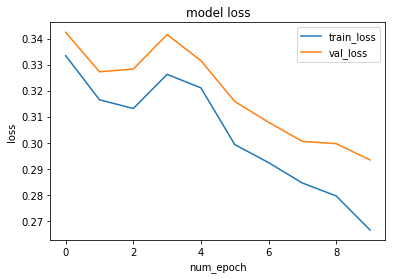

In [78]:
scratch_snn = ScratchSimpleNeuralNetrowkClassifier(num_epoch=10, lr=1e-2, verbose=True)
scratch_snn.fit(X_train_, y_train_, X_val, y_val)
y_pred = scratch_snn.predict(X_test)

In [81]:
print(y_pred)
print(y_pred.shape)

[7 2 1 ... 4 5 6]
(10000,)


In [82]:
evaluate(y_test, y_pred)

accuracy = 0.9176
precision = 0.9186519593746642
recall = 0.9166311292199832
f1 = 0.9166525775417107
[[ 951    0    2    3    2   14    2    3    3    0]
 [   0 1099    5    3    0    5    0    1   22    0]
 [   9    2  952    7    9    7    4    7   34    1]
 [   2    1   24  893    1   46    1    7   33    2]
 [   1    1    6    1  928    2    9    5   17   12]
 [   9    1    8   15    4  781    5    3   62    4]
 [  16    1   13    0    9   39  865    1   14    0]
 [   1    9   31    6    9    2    0  947    4   19]
 [   8    4   10   16    7   20    2    6  898    3]
 [   9    2    4   12   66   13    0   20   21  862]]


In [77]:
scratch_snn.forward_propagation(X_test)

array([[4.16079840e-04, 4.70426827e-05, 4.36778170e-04, ...,
        9.95113452e-01, 6.38934449e-05, 1.03711230e-03],
       [1.28657128e-02, 2.57810611e-03, 6.08870978e-01, ...,
        1.37600387e-06, 3.79340741e-02, 9.13256296e-05],
       [1.68794543e-05, 9.93230624e-01, 4.36761131e-04, ...,
        5.00564634e-05, 4.29219578e-03, 9.96217248e-06],
       ...,
       [7.22205398e-06, 1.37609402e-05, 2.09000001e-04, ...,
        1.32900053e-03, 9.06911215e-03, 5.92679933e-04],
       [4.02787233e-05, 7.38283689e-05, 1.44346616e-04, ...,
        4.63627777e-05, 1.15893962e-01, 1.33617401e-05],
       [1.90492243e-03, 2.95164753e-04, 4.05474152e-03, ...,
        1.26810719e-05, 2.00682776e-04, 1.71593026e-06]])

In [57]:
scratch_snn.A2

array([[ 1.03429881e-06,  1.27422481e-06,  1.03020028e-06, ...,
        -1.77496714e-06, -1.21637329e-06,  1.22396945e-06],
       [ 1.02531856e-06,  1.32545996e-06,  1.02039359e-06, ...,
        -1.74775350e-06, -1.20191620e-06,  1.18970818e-06],
       [ 1.01706940e-06,  1.30744510e-06,  1.02605561e-06, ...,
        -1.76504187e-06, -1.19826076e-06,  1.22387343e-06],
       ...,
       [ 1.04080546e-06,  1.28243488e-06,  1.01956205e-06, ...,
        -1.76482168e-06, -1.19590496e-06,  1.22414575e-06],
       [ 1.02037686e-06,  1.29744340e-06,  1.01136767e-06, ...,
        -1.76827886e-06, -1.24979045e-06,  1.21298621e-06],
       [ 1.01543470e-06,  1.29140341e-06,  1.03501698e-06, ...,
        -1.79375554e-06, -1.17143640e-06,  1.22231570e-06]])

In [60]:
np.tanh(scratch_snn.A2)
for i in range(10):
    print(np.tanh(10**(-i)))

0.7615941559557649
0.09966799462495582
0.00999966667999946
0.0009999996666668
9.999999966666667e-05
9.999999999666668e-06
9.999999999996666e-07
9.999999999999966e-08
1e-08
1e-09


In [28]:
print(scratch_snn.w1)
print(scratch_snn.w2)
print(scratch_snn.w3)

[[ 7.92545850e-06 -1.45091585e-06 -1.28713287e-05 ... -2.45453396e-06
  -3.46064133e-05  7.58268903e-06]
 [-1.37276398e-06  2.78289181e-06  9.32825728e-06 ... -1.49558056e-05
   9.68798389e-06  1.01331950e-05]
 [-7.46748302e-06  9.05244991e-06  6.03802443e-07 ...  1.24915526e-05
  -5.29285034e-06  7.30488414e-06]
 ...
 [-8.11822948e-06  1.00227495e-05 -1.82601833e-06 ...  3.78093044e-06
   2.12647825e-05 -1.42446555e-05]
 [-4.37306214e-06 -9.40798137e-06 -3.87237158e-06 ... -1.87630068e-05
   5.12501424e-06 -6.29033879e-07]
 [ 9.09606425e-06  4.15441632e-06 -5.21813514e-06 ...  1.91872303e-05
  -6.67915222e-06  3.16757245e-06]]
[[-1.23373141e-05  7.87399728e-06  1.61129686e-06 ... -1.06920180e-05
   5.95086000e-06 -2.88162368e-06]
 [ 4.67382713e-06 -7.99554090e-06  2.32841045e-05 ...  5.91002225e-06
  -1.78878562e-05  3.97923004e-06]
 [-1.16057600e-05 -6.09463798e-07  2.32607231e-06 ...  1.10833918e-05
   2.23593982e-06 -2.12190142e-07]
 ...
 [-2.43516211e-05 -1.83299051e-05 -5.3611854

In [23]:
scratch_snn.A3

array([[-0.00831709,  0.12157454, -0.00417588, ...,  0.04384136,
        -0.03380383,  0.00968825],
       [-0.00831709,  0.12157454, -0.00417588, ...,  0.04384136,
        -0.03380383,  0.00968825],
       [-0.00831709,  0.12157454, -0.00417588, ...,  0.04384136,
        -0.03380383,  0.00968825],
       ...,
       [-0.00831709,  0.12157454, -0.00417588, ...,  0.04384136,
        -0.03380383,  0.00968825],
       [-0.00831709,  0.12157454, -0.00417588, ...,  0.04384136,
        -0.03380383,  0.00968825],
       [-0.00831709,  0.12157454, -0.00417588, ...,  0.04384136,
        -0.03380383,  0.00968825]])

In [24]:
set(np.argmax(scratch_snn.A3, axis=1))

{1}

In [25]:
scratch_snn.b

[]

## 【問題7】学習曲線のプロット

ScratchSimpleNeuralNetrowkClassifier クラスに learning_curve メソッドを追加し、 fit メソッドに書き加えた。  

## 【問題8】（アドバンス課題）誤分類の確認

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


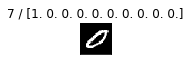

In [83]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""

num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')